---
layout: page
title: Inflation
---

In [27]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from IPython.display import display, Markdown

from data_loader import load_csv_data, get_last_publish_date
from chart_format import StandardChart, PercentileChart

The Consumer Price Index that the Reserve Bank of Australia use to index inflation is published quarterly, one month after the end of each quarter.

In [28]:
""" Load data 
RBA Inflation Rate (Consumer Price Index) is released quarterly, 
and the monthly CPI 'indicator' that includes 2/3rds of the CPI basket is released monthly.
Q3 2023 was published on last thursday of month Thu 26 Oct 2023. Q4 should be expected Thu 25 Jan 2024 but not published on Thu 25 or 26 (public holiday) 27 Sat, 28 or 29.
"""
# RBA quarterly inflation rates from 1922
# Rates are published in the month after the quarter ends.
# E.g. the rate for 2024Q1 Jan to March is published end of April 2024.
publish_date = get_last_publish_date()

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'

# First 10 rows are descriptive header rows
skip_rows = 10

df = load_csv_data(local_file, csv_url, publish_date, skip_rows)

In [29]:
""" Data Transformation """
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year
data_column = 'GCPIAGYP'

# Series ID dates are in the format 'Jan-1959' %b-%Y
df['Date'] = df['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df.set_index('Date', inplace=True)

last_index = df[data_column].last_valid_index()
# only include rows up to the last_index (drop the NaN rows at end of file)
df = df.loc[:last_index]

Inflation rocketed through the roof in the 1970s peaking at 18% in 1975. 

Inflation remained highly volatile but eventually stabilized through the 1990s, and was trending slightly down through the 2000s until the spike back up to 8% at the end of 2022.

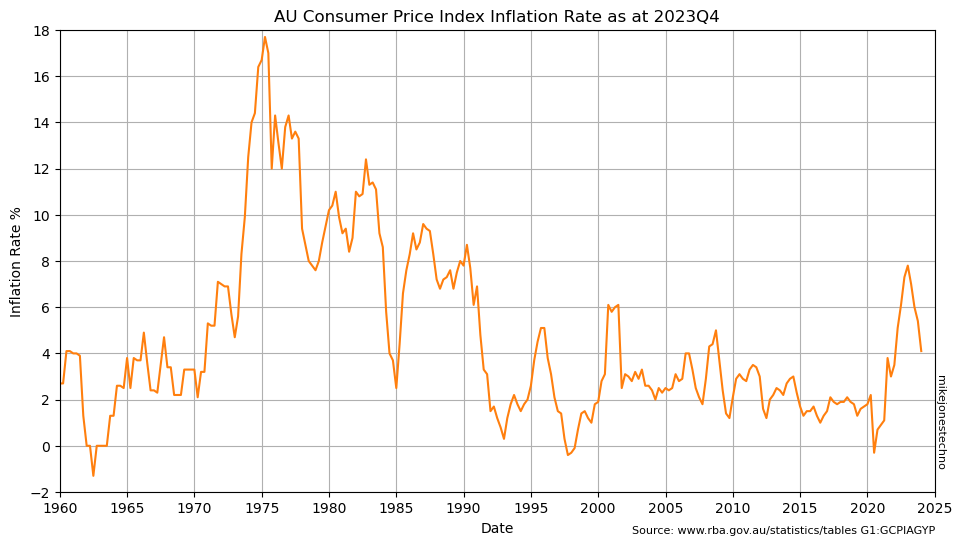

In [30]:
""" Show simple chart """

chart_params = {
    'chart_title': 'AU Consumer Price Index Inflation Rate as at ' + str(pd.Period(str(last_index), freq='Q')), 
    'chart_source': 'Source: www.rba.gov.au/statistics/tables G1:GCPIAGYP', 
    'y_label': 'Inflation Rate %', 
    'y_ticks': 2,
    'x_label': 'Date', 
    'x_ticks': 5,
    'start_year': 1960,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[1]['color'])

plt.show()

In [31]:
""" Calculate median 50th and lower, upper percentiles over multiple years """
periods_per_year = 4
multi_year = 10
multi_year_extended = 3

multi_years = [10, 20, 30]

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)

window_periods = [
    periods_per_year,
    periods_per_year * multi_years[0],
    periods_per_year * multi_years[1],
    periods_per_year * multi_years[2]
]

def add_percentiles(df, column, window, prefix):
    """Calculate and add percentiles to the DataFrame for a given window size."""
    for percentile_name, percentile in zip(percentiles._fields, percentiles):
        df[f'{prefix}_{percentile_name}'] = df[column].rolling(window=window).quantile(percentile/100)

# Calculate and add the percentiles for each window size
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    add_percentiles(df, data_column, window, name)


In [32]:
""" Create a markdown data table of the multi year percentiles to reuse in other notebooks """

# Create the header rows of the table
table = "| Years |   " + " |   ".join(f'{str(percentile)}' for percentile in percentiles) + " |\n"
table += "|-------" + "|-----:" * len(Percentiles._fields) + "|\n"

# Add the percentile values for each window period
for window in window_periods:
    years = window // periods_per_year
    name = f'rolling_{years}_years'
    table += f"| {str(years).ljust(5)} | " + " | ".join("{:,.2f}".format(df[f'{name}_{percentile_name}'].iloc[-1]) for percentile_name in Percentiles._fields) + " |\n"

In [33]:
with open('../data/inflation_percentiles.md', 'w') as f:
    f.write(table)
    f.close()

In [34]:
display(Markdown(f"""
Calculating the {percentiles[0]}th and {percentiles[2]}th percentile over a multi year time horizon helps smooth out the anomolies and visualize the {Percentiles._fields[0]} and {Percentiles._fields[2]} long term trends.
"""))


Calculating the 25th and 75th percentile over a multi year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.


In [35]:
def add_horizontal_band(plt):
    # Add a horizontal band between y=2 and y=3
    plt.fill_between(df.index, 2, 3, color=colors[1]['color'], alpha=0.1)
    # Create a Patch for the legend
    target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
    # Get the existing legend entries
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # Add the patch to the existing handles
    handles.append(target_range)
    plt.legend(handles=handles, loc=chart_params['legend_location'])
    return plt

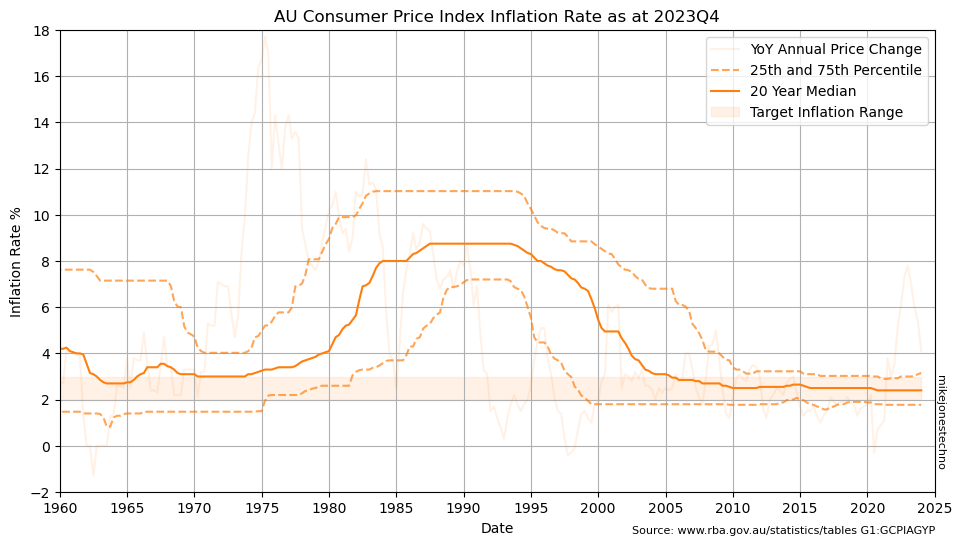

In [36]:
chart_params['color_index'] = 1
chart_params['legend_location'] = 'best'
percentile_chart = PercentileChart(percentiles, multi_years[1], **chart_params)
plt = percentile_chart.plot_percentiles(df) 
plt = add_horizontal_band(plt)
plt.show()

In [37]:
# Replace headings for percentile column headings
headings = table.split('\n')[0].split('|')[2:-1]
updated_headings = [ heading.strip() + 'th percentile' for heading in headings]
updated_headings_row = '| Years | ' + ' | '.join(updated_headings) + ' |'
show_table = table.replace(table.split('\n')[0], updated_headings_row, 1)

display(Markdown(f"""
Over the last {multi_years[0]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[0]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

Over the last {multi_years[-1]} years the {Percentiles._fields[1]} ({percentiles[1]}th percetile) change is { "{:,.2f}".format(df[f'rolling_{multi_years[-1]}_years_{Percentiles._fields[1]}'].iloc[-1])  }%.

{show_table}
"""))


Over the last 10 years the median (50th percetile) change is 1.90%.

Over the last 30 years the median (50th percetile) change is 2.45%.

| Years | 25th percentile | 50th percentile | 75th percentile |
|-------|-----:|-----:|-----:|
| 1     | 5.08 | 5.70 | 6.25 |
| 10    | 1.50 | 1.90 | 3.12 |
| 20    | 1.77 | 2.40 | 3.15 |
| 30    | 1.70 | 2.45 | 3.23 |



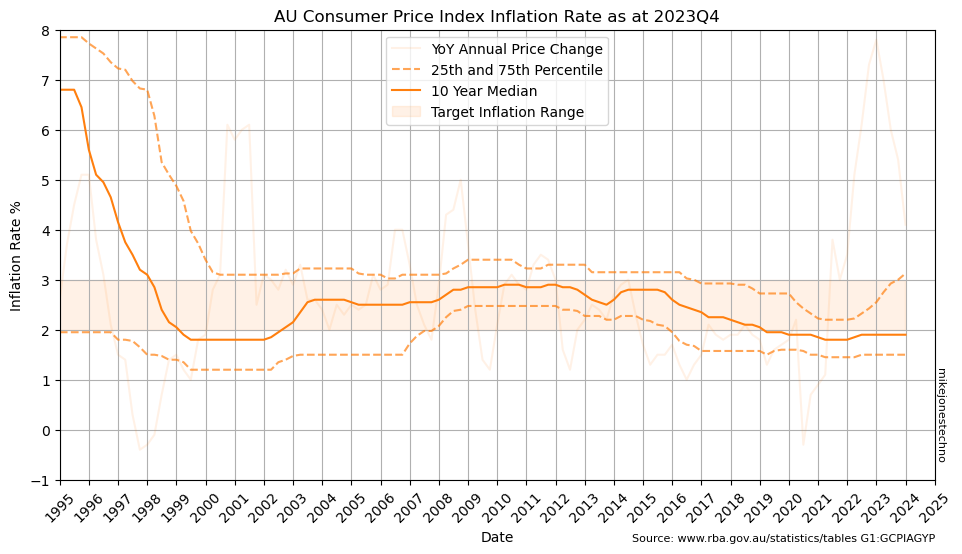

In [38]:
""" Change chart variables to plot from 1995"""

chart_params['start_year'] = 1995
chart_params['end_year'] = 2025 # set end year to multiple of old x_ticks before we change to 1 year ticks.
chart_params['y_ticks'] = 1
chart_params['x_ticks'] = 1
chart_params['legend_location'] = 'upper center'

percentile_chart = PercentileChart(percentiles, multi_years[0], **chart_params)
plt = percentile_chart.plot_percentiles(df)
plt = add_horizontal_band(plt)
plt.show()

The chart shows inflation stayed close to the RBA target inflation rate of 2 to 3 percent for over twenty five years.

> ℹ The data suggests high confidence using a baseline inflation of 2.5% with some uncertainty or risk that inflation could peak higher.

In [39]:
%%capture
# Magic store dataframe to share with combo notebook
df_inflation = df
%store df_inflation